In [41]:
from datasets import load_dataset

ds_book_corpus = load_dataset("bookcorpus/bookcorpus", trust_remote_code=True)

In [139]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
import torch.nn.functional as F
import numpy as np

# Load the RoBERTa model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

# def calculate_perplexity(sentence, model, tokenizer):
#     encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True)
#     input_ids = encoded_input['input_ids'].squeeze()  # Shape: [seq_len]
#     attention_mask = encoded_input['attention_mask']
    
#     total_log_prob = 0.0
#     N = len(input_ids)
    
#     for i in range(1, N-1):  # Skip [CLS] and [SEP] if present
#         masked_input_ids = input_ids.clone()  # Clone to avoid in-place modification
#         masked_input_ids[i] = tokenizer.mask_token_id  # Mask the i-th token
        
#         # Predict the masked token
#         with torch.no_grad():
#             outputs = model(input_ids=masked_input_ids.unsqueeze(0), attention_mask=attention_mask)
#             logits = outputs.logits
        
#         # Convert logits to probabilities
#         predicted_probs = F.softmax(logits[0, i], dim=-1)
        
#         # Get the probability of the original token
#         original_token_id = input_ids[i].item()
#         original_token_prob = predicted_probs[original_token_id].item()
        
#         # Add the log probability of the original token
#         total_log_prob += np.log(original_token_prob)
    
#     # Compute pseudo-perplexity
#     avg_log_prob = total_log_prob / (N - 2)  # Exclude [CLS] and [SEP] tokens
#     pseudo_perplexity = np.exp(-avg_log_prob)
    
#     return pseudo_perplexity

def score(sentence, model, tokenizer):
    # https://arxiv.org/abs/1910.14659
    tensor_input = tokenizer(sentence, return_tensors='pt', truncation=True)
    repeat_input = tensor_input['input_ids'].repeat(tensor_input['input_ids'].size(-1)-2, 1)
    mask = torch.ones(tensor_input['input_ids'].size(-1) - 1).diag(1)[:-2]
    masked_input = repeat_input.masked_fill(mask == 1, tokenizer.mask_token_id)
    labels = repeat_input.masked_fill( masked_input != tokenizer.mask_token_id, -100)
    with torch.inference_mode():
        loss = model(masked_input, labels=labels).loss
    return np.exp(loss.item())


# Example usage
sentence = "London is the capital of Great Britain."
pseudo_perplexity = score(sentence, model, tokenizer)
print("Pseudo-perplexity:", pseudo_perplexity)



Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Pseudo-perplexity: 1.0968683577162155


In [144]:
file_path = "generations_1000.txt"
perplexities = []
zlib_entripies = []
texts = []
ids = []
import zlib
from tqdm import tqdm
with open(file_path, 'r') as f:
    lines = f.readlines()
    for line_idx, line in tqdm(enumerate(lines), total=len(lines)):
        perpl = score(line, model, tokenizer)
        zlib_entropy = len(zlib.compress(bytes(line, 'utf-8')))
        perplexities.append(perpl)
        zlib_entripies.append(zlib_entropy)

        if line_idx>100:
            break

  5%|▌         | 101/2000 [00:48<15:08,  2.09it/s]


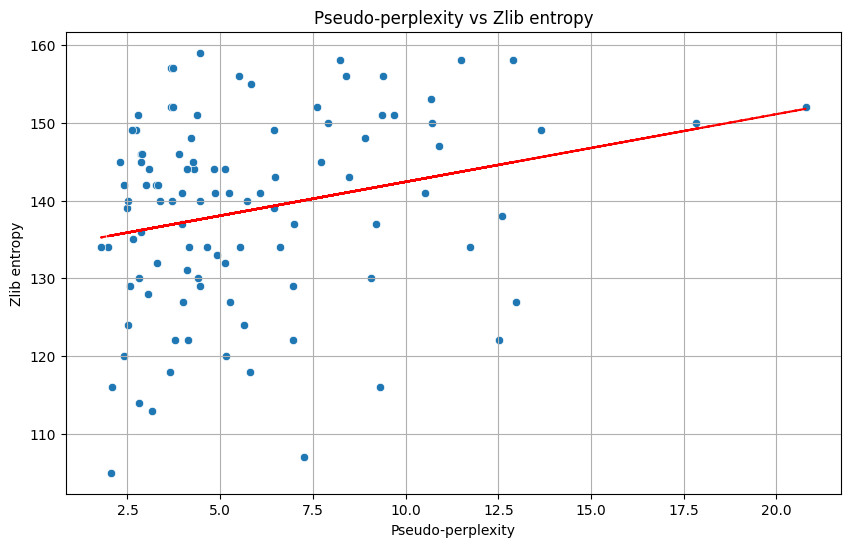

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perplexities, y=zlib_entripies, data=ds_book_corpus['train'])
plt.xlabel('Pseudo-perplexity')
plt.ylabel('Zlib entropy')
plt.title('Pseudo-perplexity vs Zlib entropy')
z = np.polyfit(perplexities, zlib_entripies, 1)
p = np.poly1d(z)
plt.plot(perplexities,p(perplexities),"r--")
plt.grid()

plt.show()
